# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch17/ch17_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torchvision': '0.9.0',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] Your Python version is 3.8.7 (default, Dec 21 2020, 20:10:35) 
[GCC 7.5.0]
[OK] torch 1.9.0+cu111
[OK] torchvision 0.10.0+cu111
[FAIL] numpy 1.19.4, please upgrade to >= 1.21.2
[FAIL] matplotlib 3.3.3, please upgrade to >= 3.4.3


# 새로운 데이터 합성을 위한 생성적 적대 신경망 (파트 1/2)

**목차**

- 생성적 적대 신경망 소개
  - 오토인코더
  - 새로운 데이터 합성을 위한 생성 모델
  - GAN으로 새로운 샘플 생성
  - GAN의 생성자와 판별자 손실 함수 이해
- 밑바닥부터 GAN 모델 구현
  - 구글 코랩에서 GAN 모델 훈련
  - 생성자와 판별자 신경망 구현
  - 훈련 데이터셋 정의
  - GAN 모델 훈련하기

In [3]:
from IPython.display import Image
%matplotlib inline

# 생성적 적대 신경망 소개

## 오토인코더


In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_01.png', width=500)

## 새로운 데이터 합성을 위한 생성 모델


In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_02.png', width=700)

## GAN으로 새로운 샘플 생성


In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_03.png', width=700)

## GAN의 생성자와 판별자 손실 함수 이해


In [7]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_04.png', width=800)

# 밑바닥부터 GAN 모델 구현


## 구글 코랩에서 GAN 모델 훈련


In [8]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_05.png', width=700)

In [9]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_06.png', width=600)

In [10]:
import torch


print(torch.__version__)
print("GPU 사용:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.9.0+cu111
GPU 사용: True


In [11]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
#from google.colab import drive
#drive.mount('/content/drive/')

## 생성자와 판별자 신경망 구현


In [13]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_08.png', width=600)

In [14]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_17.png', width=600)

In [15]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
## 생성자 함수 정의
def make_generator_network(
        input_size=20,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}',
                         nn.Linear(input_size,
                                   num_hidden_units))
        model.add_module(f'relu_g{i}',
                         nn.LeakyReLU())
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}',
                    nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model

## 판별자 함수 정의
def make_discriminator_network(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}',
                 nn.Linear(input_size,
                           num_hidden_units, bias=False))
        model.add_module(f'relu_d{i}',
                         nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}',
                     nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [17]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [18]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 훈련 데이터셋 정의


 * **데이터 흐름에 따라 단계적으로 처리**

In [19]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

example, label = next(iter(mnist_dataset))
print(f'최소: {example.min()} 최대: {example.max()}')
print(example.shape)

최소: -1.0 최대: 1.0
torch.Size([1, 28, 28])


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [20]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [21]:
from torch.utils.data import DataLoader


batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'  # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_proba_real.shape)
print('판별자 (가짜) -- 크기:', d_proba_fake.shape)

input-z -- 크기: torch.Size([32, 20])
input-real -- 크기: torch.Size([32, 784])
생성자 출력 -- 크기: torch.Size([32, 784])
판별자 (진짜) -- 크기: torch.Size([32, 1])
판별자 (가짜) -- 크기: torch.Size([32, 1])


## GAN 모델 훈련하기

In [22]:
loss_fn = nn.BCELoss()

## 생성자 손실
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

## 판별자 손실
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'판별자 손실: 진짜 {d_loss_real:.4f} 가짜 {d_loss_fake:.4f}')

Generator Loss: 0.6983
판별자 손실: 진짜 0.7479 가짜 0.6885


 * **최종 훈련**

In [23]:
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## 데이터셋 생성
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

## 모델 생성
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)

## 손실 함수와 옵티마이저:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [24]:
## 판별자 훈련
def d_train(x):
    disc_model.zero_grad()

    # 진짜 배치에서 판별자 훈련
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # 가짜 배치에서 판별자 훈련
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # 그레이디언트 역전파와 판별자 파라미터 최적화
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [25]:
## 생성자 훈련
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # 그레이디언트 역전파와 생성자 파라미터 최적화
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

*아래 셀은 실행하는데 오래 걸립니다*

In [26]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [판별자-진짜: {all_d_real[-1]:.4f} 판별자-가짜: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 평균 손실 >> 생성자/판별자 0.8919/0.9083 [판별자-진짜: 0.8042 판별자-가짜: 0.4729]
에포크 002 | 평균 손실 >> 생성자/판별자 0.9119/1.1617 [판별자-진짜: 0.6016 판별자-가짜: 0.4403]
에포크 003 | 평균 손실 >> 생성자/판별자 1.0379/1.1443 [판별자-진짜: 0.6042 판별자-가짜: 0.4090]
에포크 004 | 평균 손실 >> 생성자/판별자 0.9875/1.1804 [판별자-진짜: 0.5950 판별자-가짜: 0.4159]
에포크 005 | 평균 손실 >> 생성자/판별자 0.9415/1.2105 [판별자-진짜: 0.5795 판별자-가짜: 0.4232]
에포크 006 | 평균 손실 >> 생성자/판별자 0.9363/1.2158 [판별자-진짜: 0.5702 판별자-가짜: 0.4224]
에포크 007 | 평균 손실 >> 생성자/판별자 0.9266/1.2185 [판별자-진짜: 0.5737 판별자-가짜: 0.4257]
에포크 008 | 평균 손실 >> 생성자/판별자 1.0838/1.1522 [판별자-진짜: 0.6010 판별자-가짜: 0.3965]
에포크 009 | 평균 손실 >> 생성자/판별자 0.9978/1.1890 [판별자-진짜: 0.5899 판별자-가짜: 0.4138]
에포크 010 | 평균 손실 >> 생성자/판별자 0.9578/1.1876 [판별자-진짜: 0.5889 판별자-가짜: 0.4175]
에포크 011 | 평균 손실 >> 생성자/판별자 0.9176/1.2381 [판별자-진짜: 0.5673 판별자-가짜: 0.4313]
에포크 012 | 평균 손실 >> 생성자/판별자 0.9321/1.2457 [판별자-진짜: 0.5659 판별자-가짜: 0.4306]
에포크 013 | 평균 손실 >> 생성자/판별자 0.9390/1.2215 [판별자-진짜: 0.5751 판별자-가짜: 0.4243]
에포크 014 | 평균 손실 >> 생성자/판별자 0.9796/1.2183 [판별자-진짜: 0

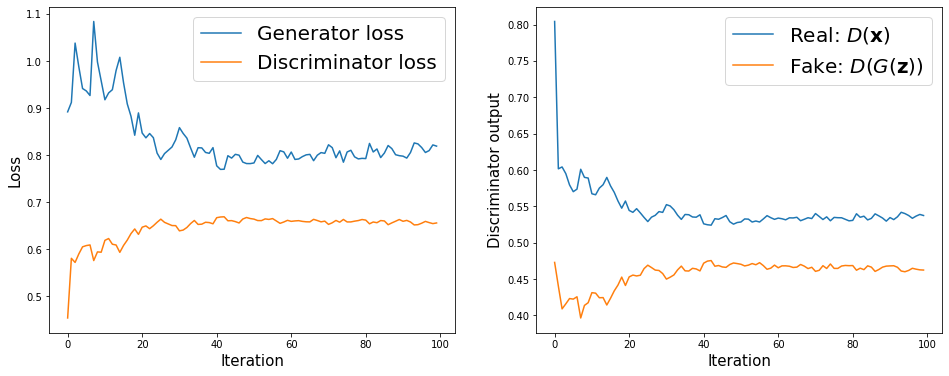

In [27]:
import itertools


fig = plt.figure(figsize=(16, 6))

## 손실 그래프
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## 판별자 출력의 그래프
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

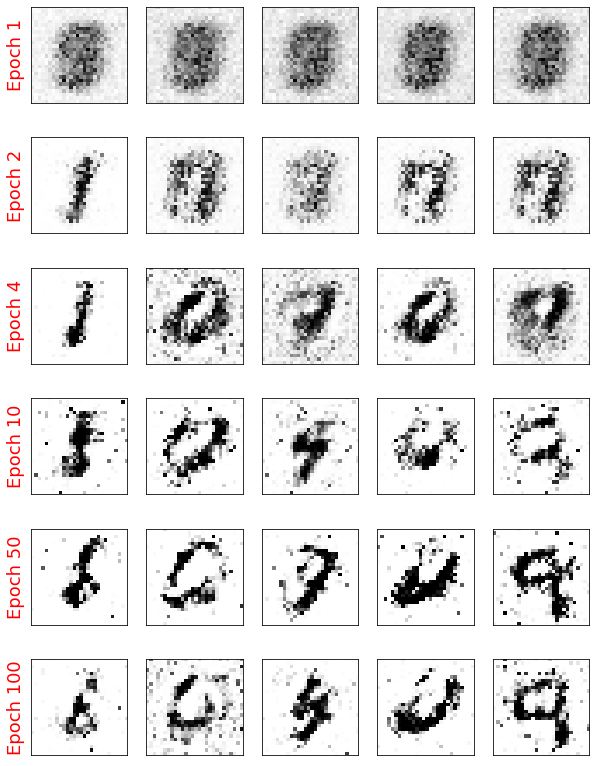

In [28]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

#plt.savefig('figures/ch17-vanila-gan-samples.pdf')
plt.show()

<br>
<br>

----

In [29]:
import math


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1).cuda()
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1).cuda()
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M+M.abs())/2).sqrt()

    return M

In [30]:
def mmd(Mxx, Mxy, Myy, sigma) :
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx/(scale*2*sigma*sigma))
    Mxy = torch.exp(-Mxy/(scale*2*sigma*sigma))
    Myy = torch.exp(-Myy/(scale*2*sigma*sigma))
    a = Mxx.mean()+Myy.mean()-2*Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [31]:
def compute_score(fake, real , k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)


    print(mmd(Mxx, Mxy, Myy, sigma))

In [32]:
whole_dl = DataLoader(mnist_dataset, batch_size=10000,
                      shuffle=True, drop_last=True)

In [33]:
real_image = next(iter(whole_dl))[0]

In [34]:
compute_score(torch.from_numpy(epoch_samples[-1]), real_image)

0.896277210508861
